In [1]:
from utils import *
import matplotlib.pyplot as plt


/home/roboworks/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [12]:
points_msg=rospy.wait_for_message("/hsrb/head_rgbd_sensor/depth_registered/rectified_points",PointCloud2,timeout=5)

In [13]:
points_data = ros_numpy.numpify(points_msg)    
image_data = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]   
image=cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
image = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB) 

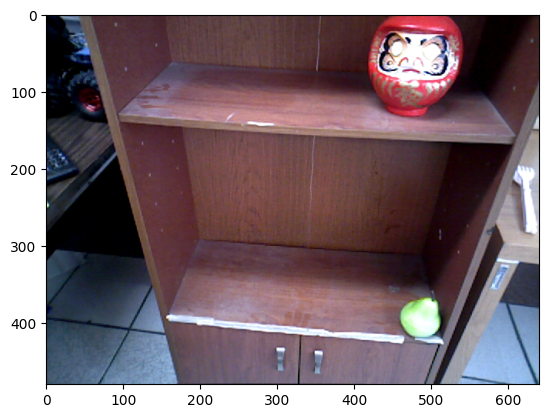

In [14]:
plt.imshow(rgb_image)

In [15]:
try:
        trans = tfBuffer.lookup_transform('map', 'head_rgbd_sensor_link', rospy.Time())
                    
        trans,rot=read_tf(trans)
        #print ("############head",trans,rot)
except (tf2_ros.LookupException, tf2_ros.ConnectivityException, tf2_ros.ExtrapolationException):
        print ( 'No head TF FOUND')
t= write_tf(trans,rot)
cloud_out = do_transform_cloud(points_msg, t)

In [16]:
np_corrected=ros_numpy.numpify(cloud_out)
corrected=np_corrected.reshape(points_data.shape)

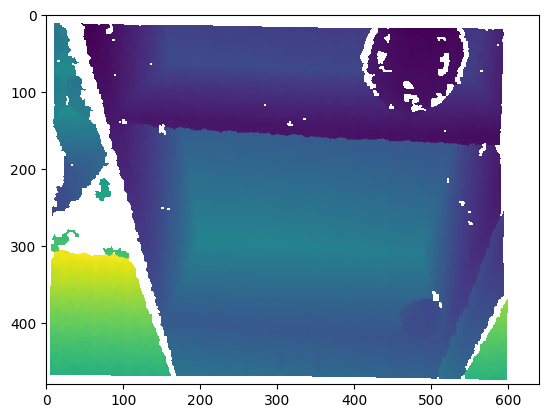

In [17]:
plt.imshow(points_data['z'])

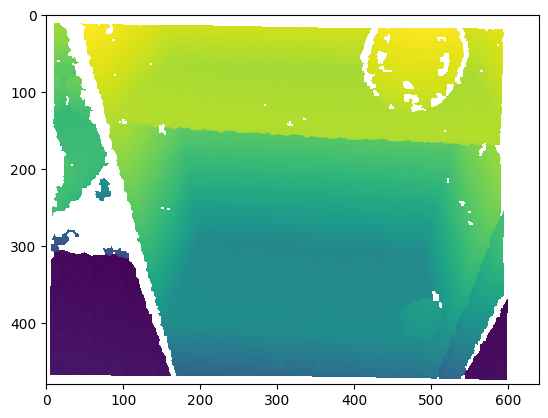

In [18]:
plt.imshow(corrected['z'])

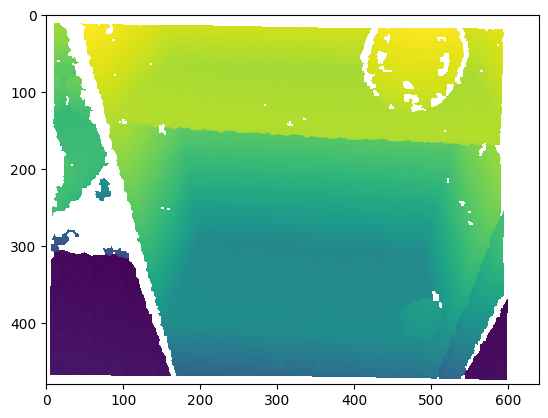

In [19]:
img_z=corrected['z']
plt.imshow(img_z)

In [20]:
lower=100
higher=10000


143.0
0.9241136164665222
Pca.explained_variance_ [6.5758453e-05 4.3851749e-05 2.7910116e-06]
[ 63.24504502  -0.25400469 -90.70812676]
164.0
0.8890559940338135
Pca.explained_variance_ [1.90801406e-03 4.34613685e-05 1.33851345e-05]
[ 50.07407217  36.33596274 -65.25456197]


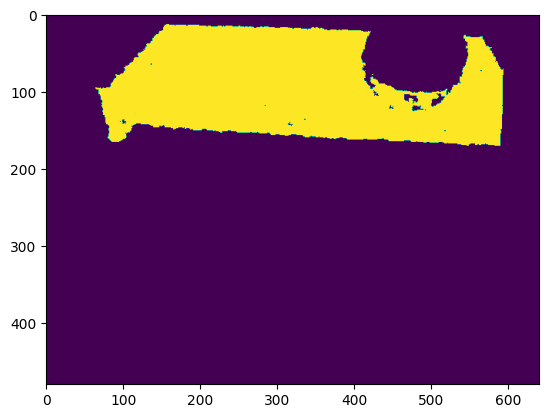

In [36]:
### MODIFICATION FOR STORING GRECIES, FINDING PLACING PLANE
orig_image= rgb_image.copy()
mask= np.zeros(corrected['z'].shape)#mask
low_plane = (corrected['z'] > 0.865) #plane height
high_plane = (corrected['z'] < 0.95)#plane height + obj height
high_x = (corrected['x'] > 7.8)
low_x = (corrected['x'] < 8.25)
#x coords placing plane limit
z_lims=np.logical_and(low_plane, high_plane)
x_lims=np.logical_and(low_x, high_x)
result_indices = np.where(z_lims)#np.logical_and(z_lims, x_lims))

mask[result_indices]=200
_, binary_image = cv2.threshold(mask, 20, 255, cv2.THRESH_BINARY)

###############FOR DEBUG IMAGE
cv2_image = cv2.cvtColor(binary_image.astype(np.uint8), cv2.COLOR_GRAY2BGR) 
img=cv2.bitwise_and(orig_image, cv2_image)
image_with_contours = img.copy()
#######################################

contours, hierarchy = cv2.findContours(binary_image.astype(np.uint8) ,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cents=[]
quats_pca=[]
for contour in contours:
    # Draw contours on the image
    area = cv2.contourArea(contour)    
    if area > lower and area < higher :  #### AREA IN PIXELS ( USEFUL TO AVOID WALLS OR OTHER BIG CLUSTRS)
        print(area)        
        boundRect = cv2.boundingRect(contour)
        mask = np.zeros_like(binary_image) 
        mask=cv2.rectangle(mask,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,255,255), -1)
        individual_mask=(mask*binary_image).astype(np.uint8)        
        cent=np.asarray(   ((  np.nanmean(corrected['x'][np.where(individual_mask==1)]) ,np.nanmean(corrected['y'][np.where(individual_mask==1)]),np.nanmean(corrected['z'][np.where(individual_mask==1)])       ))      )
        cents.append(cent)        
        ################################PCA
        points_c=np.asarray((corrected['x'][np.where(individual_mask==1)],corrected['y'][np.where(individual_mask==1)],corrected['z'][np.where(individual_mask==1)]))
        E_R=points_to_PCA(points_c.transpose())
        e_ER=tf.transformations.euler_from_matrix(E_R)
        quat= tf. transformations.quaternion_from_euler(e_ER[0],e_ER[1],e_ER[2])
        quats_pca.append(quat)
        print(np.rad2deg(tf.transformations.euler_from_matrix(E_R)))
        #######FOR DEBUG IMAGE
        cv2.drawContours(image_with_contours, contour, -1, (0, 255, 0), 2)  # -1 draws all contours
        rgb_image=cv2.rectangle(image_with_contours,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,255,0), 2)

        
#plt.imshow(img)
plt.imshow (binary_image)

/home/roboworks/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/roboworks/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


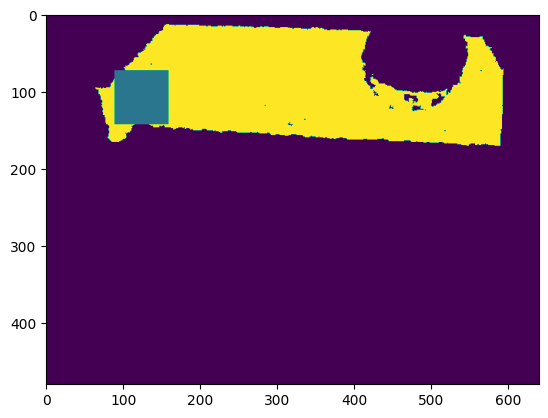

In [37]:
xs,ys=np.where(binary_image==255 )[0] ,np.where(binary_image==255 )[1]
for x,y  in zip(xs,ys):
    if np.mean(binary_image[y-35:y+35,x-35:x+35]) >250:
        binary_image[y-35:y+35,x-35:x+35]=100
plt.imshow(binary_image)


In [ ]:
np.where(binar)

In [ ]:
orig_image= rgb_image.copy()
mask= np.zeros(corrected['z'].shape)#mask
low_plane = (corrected['z'] > 0.07) #plane height
high_plane = (corrected['z'] < 0.12)#plane height + obj height
result_indices = np.where(np.logical_and(low_plane, high_plane))
mask[result_indices]=200
_, binary_image = cv2.threshold(mask, 20, 255, cv2.THRESH_BINARY)

###############FOR DEBUG IMAGE
cv2_image = cv2.cvtColor(binary_image.astype(np.uint8), cv2.COLOR_GRAY2BGR) 
img=cv2.bitwise_and(orig_image, cv2_image)
image_with_contours = img.copy()
#######################################

contours, hierarchy = cv2.findContours(binary_image.astype(np.uint8) ,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cents=[]
quats_pca=[]
for contour in contours:
    # Draw contours on the image
    area = cv2.contourArea(contour)    
    if area > lower and area < higher :  #### AREA IN PIXELS ( USEFUL TO AVOID WALLS OR OTHER BIG CLUSTRS)
        print(area)        
        boundRect = cv2.boundingRect(contour)
        mask = np.zeros_like(binary_image) 
        mask=cv2.rectangle(mask,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,255,255), -1)
        individual_mask=(mask*binary_image).astype(np.uint8)        
        cent=np.asarray(   ((  np.nanmean(corrected['x'][np.where(individual_mask==1)]) ,np.nanmean(corrected['y'][np.where(individual_mask==1)]),np.nanmean(corrected['z'][np.where(individual_mask==1)])       ))      )
        cents.append(cent)        
        ################################PCA
        points_c=np.asarray((corrected['x'][np.where(individual_mask==1)],corrected['y'][np.where(individual_mask==1)],corrected['z'][np.where(individual_mask==1)]))
        E_R=points_to_PCA(points_c.transpose())
        e_ER=tf.transformations.euler_from_matrix(E_R)
        quat= tf. transformations.quaternion_from_euler(e_ER[0],e_ER[1],e_ER[2])
        quats_pca.append(quat)
        print(np.rad2deg(tf.transformations.euler_from_matrix(E_R)))
        #######FOR DEBUG IMAGE
        cv2.drawContours(image_with_contours, contour, -1, (0, 255, 0), 2)  # -1 draws all contours
        rgb_image=cv2.rectangle(image_with_contours,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,255,0), 2)

        
#plt.imshow(img)
plt.imshow (binary_image)

In [ ]:
quats_pca, cents

In [ ]:
#tf_map
for i, cent in enumerate(cents):
    x,y,z=cent
    axis=[0,0,1]
    angle = tf.transformations.euler_from_quaternion(quats_pca[i])[0]
    rotation_quaternion = tf.transformations.quaternion_about_axis(angle, axis)
    t=write_tf(    (x,y,z), rotation_quaternion, 'object'+str(i), "map"   )
    broadcaster.sendTransform(t)

In [ ]:
for i, cent in enumerate(cents):
    x,y,z=cent
    t=write_tf(    (x,y,z), (0,0,0,1), 'ref'+str(i), "map"   )
    broadcaster.sendTransform(t)

In [ ]:
new= np.zeros(img_z.shape)#mask
image= rgb_image.copy()
condition1 = (img_z > 0.39)
condition2 = (img_z < 0.41)
result_indices = np.where(np.logical_and(condition1, condition2))
image[result_indices]=np.asarray((0,0,255))

#new[np.where(img_z>=0.4)]=200
condition1 = (img_z > 0.405)
condition2 = (img_z < 0.70)
result_indices = np.where(np.logical_and(condition1, condition2))
new[result_indices]=200

plt.imshow(image)

In [ ]:
_, binary_image = cv2.threshold(new, 20, 255, cv2.THRESH_BINARY)
cv2_image = cv2.cvtColor(binary_image.astype(np.uint8), cv2.COLOR_GRAY2BGR) 
plt.imshow(binary_image)

In [ ]:
img=cv2.bitwise_and(rgb_image, cv2_image)
plt.imshow(img)

In [ ]:
contours, hierarchy = cv2.findContours(binary_image.astype(np.uint8) ,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
lower=0 
higher=10000
image_with_contours = image.copy()
len(contours)
cents=[]
points=[]
for contour in contours:
    # Draw contours on the image
    area = cv2.contourArea(contour)    
    if area > lower and area < higher :  #### AREA IN PIXELS ( USEFUL TO AVOID WALLS OR OTHER BIG CLUSTRS)
        print(area)        
        boundRect = cv2.boundingRect(contour)
        mask = np.zeros_like(binary_image) 
        mask=cv2.rectangle(mask,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,255,255), -1)
        individual_mask=(mask*binary_image).astype(np.uint8)        
        cent=np.asarray(   ((  np.nanmean(points_data['x'][np.where(individual_mask==1)]) ,np.nanmean(points_data['y'][np.where(individual_mask==1)]),np.nanmean(points_data['z'][np.where(individual_mask==1)])       ))      )
        cents.append(cent)
        cv2.drawContours(image_with_contours, contour, -1, (0, 255, 0), 2)  # -1 draws all contours
        rgb_image=cv2.rectangle(image_with_contours,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,255,0), 2)
plt.imshow (image_with_contours)
print (cents)

In [ ]:
for i, cent in enumerate(cents):
    x,y,z=cent
    t=write_tf(    (x,y,z), (0,0,0,1), 'object'+str(i), "head_rgbd_sensor_rgb_frame"   )
    broadcaster.sendTransform(t)

In [ ]:
zs_no_nans=corrected['z'][~np.isnan(corrected['z'])]
histogram, bin_edges =(np.histogram(zs_no_nans, bins=100))
plane_height= bin_edges[histogram[:-1].argmax()]
print (plane_height)

In [ ]:
hist,bins=np.histogram()])
plt.hist(img_z,bins=bins)

In [ ]:
counts, bins =(np.histogram(zs_no_nans, bins=50))
inds=np.where(counts>5000)
low_planes_height=bins[np.add(inds, 1)].flatten()

low_planes_height2=bins[inds]

In [ ]:
low_planes_height2.shape

In [ ]:
 np.add(inds, 1)

In [ ]:
zs_no_nans=corrected['z'][~np.isnan(corrected['z'])]
counts, bins =(np.histogram(zs_no_nans, bins=100))
inds=np.where(counts>5000)
print (f'Number of planes found {len(inds[0])} at z=[{bins[inds]}]')
plt.stairs(counts, bins)


In [ ]:
np.where(counts>5000)

In [ ]:
bins[np.where(counts>10000)]

In [ ]:
condition1 = (img_z > 0.4)
condition2 = (img_z < 0.402)

result_indices = np.where(np.logical_or(condition1, condition2))


In [ ]:
new[np.where(img_z<=.002)]=200
new[result_indices]=100

In [ ]:
plt.imshow(new)

In [ ]:
points_c=np.asarray((corrected['x'][np.where(individual_mask==1)],corrected['y'][np.where(individual_mask==1)],corrected['z'][np.where(individual_mask==1)]))
points_c.shape
E_R=points_to_PCA(points_c.transpose())
print(np.rad2deg(tf.transformations.euler_from_matrix(E_R)))

In [ ]:
result_indices=()
for plane_height in bins[inds]:
    low_plane_ix = (corrected['z'] > plane_height)
    high_plane_ix = (corrected['z'] > plane_height + 0.3)

    result_indices += np.where(np.logical_or(low_plane_ix, high_plane_ix))

    print (plane_height )

In [ ]:
len(result_indices[0])

In [ ]:

high_plane = (corrected['z'] < 0.99)
result_indices = np.where(np.logical_and(low_plane, high_plane))
result_indices

In [ ]:
 bins[inds].shape

In [ ]:
low_planes= bins[inds]

In [ ]:
for lp in low_planes:
    print (lp)

In [ ]:
low_plane = (corrected['z'] > 0.7)      # HEIGHT REQUESTED OR OBTAINED FROM HISTOGRAM
high_plane = (corrected['z'] < 0.7+.3)

In [ ]:
type(low_planes)